# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

from adjustText import adjust_text

In [2]:
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib
from cf_analysis_lib import read_taxonomy, read_metadata

In [3]:
datadir = ".."
sequence_type = "MGI"
taxa = "genus"
df = read_taxonomy(datadir, sequence_type, taxa)
df = df.T
df.head(3)

taxonomy,Aegiribacteria,Kapaibacterium,Stahlbacteria,Vermiphilus,Babela,Chromulinivorax,Ozemobacter,Desulfacyla,Dissulfurimicrobium,Dissulfurirhabdus,...,Oceaniferula,Persicirhabdus,Phragmitibacter,Prosthecobacter,Roseibacillus,Roseimicrobium,Sulfuriroseicoccus,Verrucomicrobium,Eremiobacter,Methylomirabilis
1068841_20180306_S,0.0,0.0,0.539042,0.0,0.0,0.0,0.0,0.0,0.269521,0.000000,...,1.347606,0.0,0.0,0.0,0.539042,0.0,0.0,0.539042,0.000000,0.000000
1085876_20180227_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.850518,0.0,0.0,0.850518,0.283506,0.283506
1128691_20171206_S,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,7.166532,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [4]:
metadata = read_metadata(datadir, sequence_type)
metadata.head(3)

,minion,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,...,Sum of meds,Sum of antifungals,Sum of steroid + mabs,DNA_extraction_ conc,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million)
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,1068841_20180306_S,1068841_20180306_S,1068841,3/06/2018,OP,RAH,Chest Clinic 7,47,7,Adult,...,0,0,0,1.070,SAGCFN_22_01754,42.8,CGCTCATT,ATAGAGGC,417,2.8
1085876_20180227_S,NaN,1085876_20180227_S,1085876,2/27/2018,OP,RAH,Chest Clinic 6,40,6,Adult,...,1,0,0,0.132,SAGCFN_22_01828,19.0,AGCGATAG,GGCTCTGA,674,2.5
1128691_20171206_S,NaN,1128691_20171206_S,1128691,12/06/2017,IP,RAH,RAH 8E 05,47,7,Adult,...,3,0,0,1.750,SAGCFN_22_01748,33.4,TCCGGAGA,GGCTCTGA,535,4.5


<Axes: xlabel='Pseudomonas', ylabel='Density'>

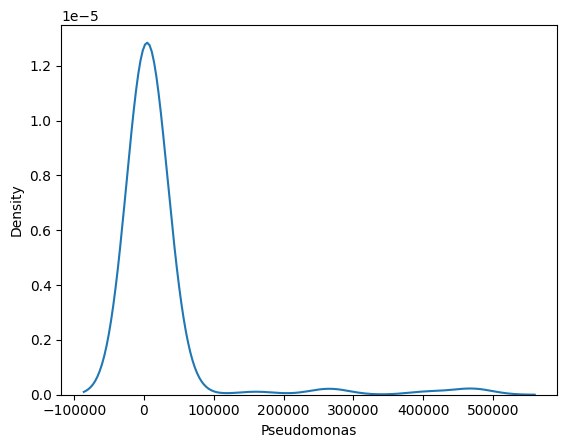

In [5]:
sns.kdeplot(data=df['Pseudomonas'])

In [6]:
genus = 'Pseudomonas'
list(df[df[genus] < 100][genus])
df[df[genus] > 0].shape

(127, 3581)

In [7]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 'Pseudomonas'
mn = np.mean(df[df[genus] > 0][genus])
md = np.median(df[df[genus] > 0][genus])
print(f"The mean for {genus} is {mn} and the median is {md}", file=sys.stderr)

nonzeromean = np.median(df[df[genus] > 0][genus])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
#bins = [-1, 200, 5000, 10000, float('inf')]
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['Pseudomonas'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['Pseudomonas'], bins=bins, labels=marker_shapes))

The mean for Pseudomonas is 20934.62682519509 and the median is 2721.3378860620664


In [8]:
df[df['Pseudomonas'] < 1000]['Pseudomonas']

1470026_20180502_S    383.930397
1862551_20180123_S    815.879856
634207_20180510_S     572.302365
634207_20180517_S     777.752846
670829_20170922_S     509.015329
676138_20171009_S     781.136834
676138_20180405_S     607.608979
701099_20180504_S     855.797795
715927_20180213_S     983.937563
715927_20180226_S     962.335690
748160_20180321_S     673.415530
748160_20180329_S     466.208402
756934_20181205_S     457.298816
Name: Pseudomonas, dtype: float64

In [9]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

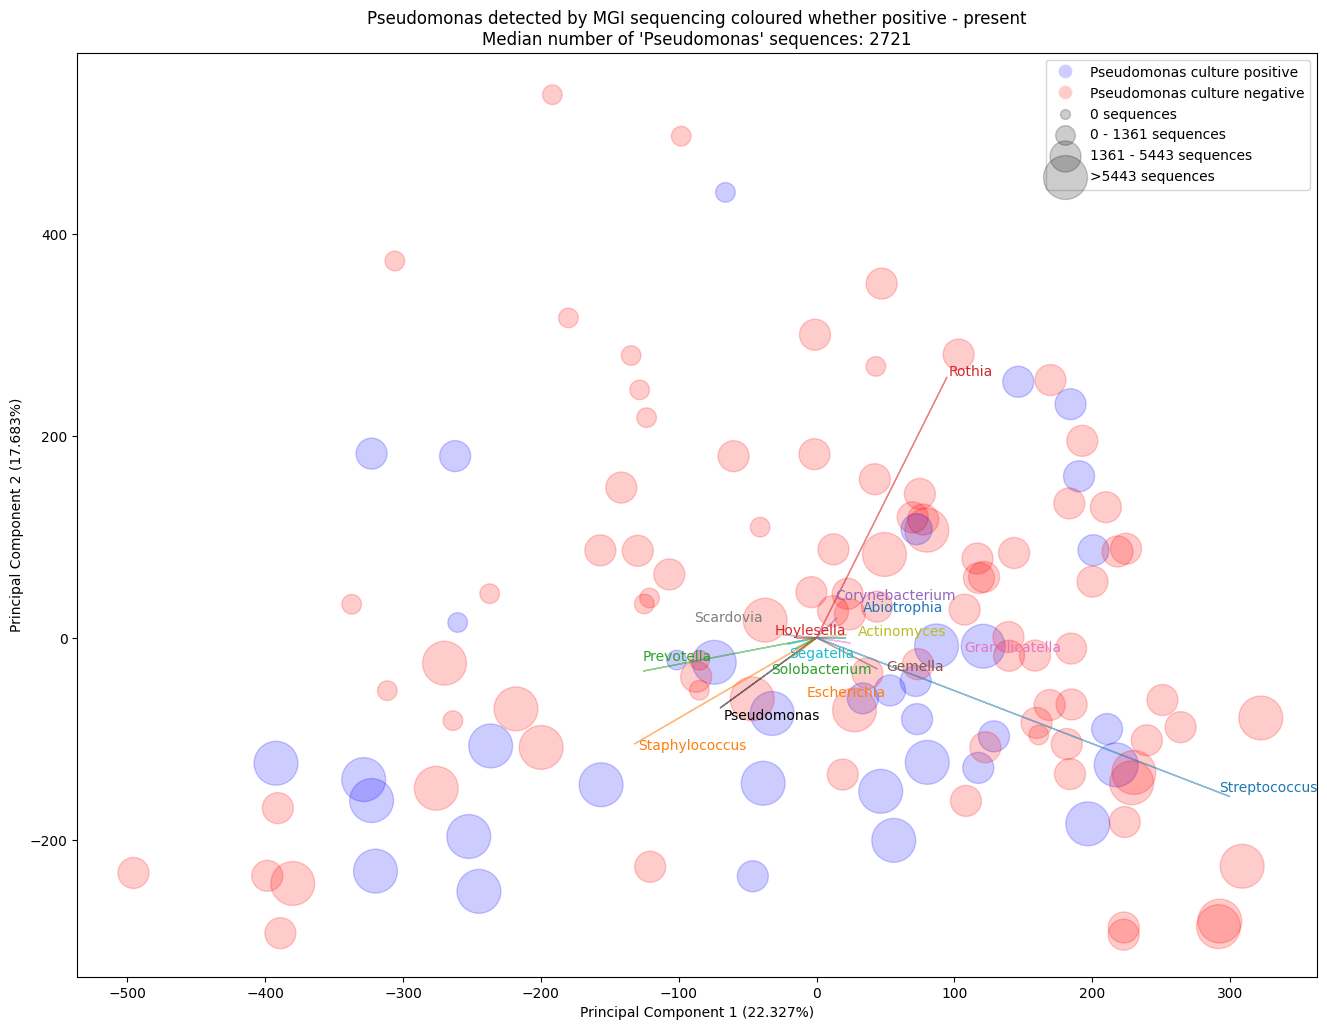

In [10]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas:
    # specifically add Pseudomonas
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))


    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


# plt.savefig('img/MGI_genus_pseudomonas_present.png')
# Show the plot
plt.show()

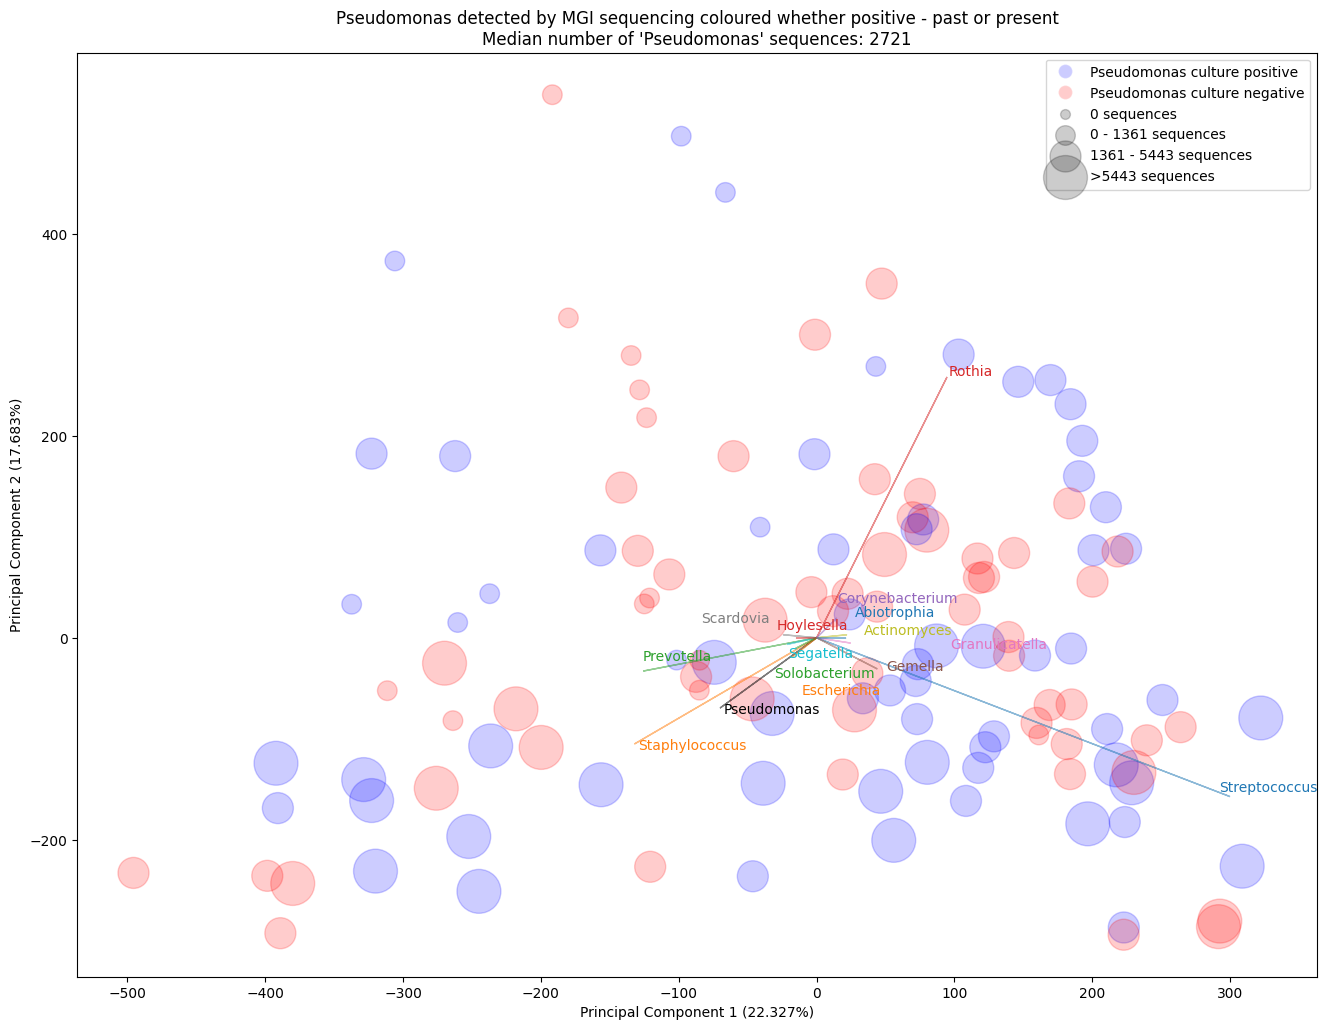

In [11]:
# Map colors based on the metadata column
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MGI sequencing coloured whether positive - past or present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas:
    # specifically add Pseudomonas
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))


    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


# plt.savefig('img/MGI_genus_pseudomonas_past_present.png')
# Show the plot
plt.show()

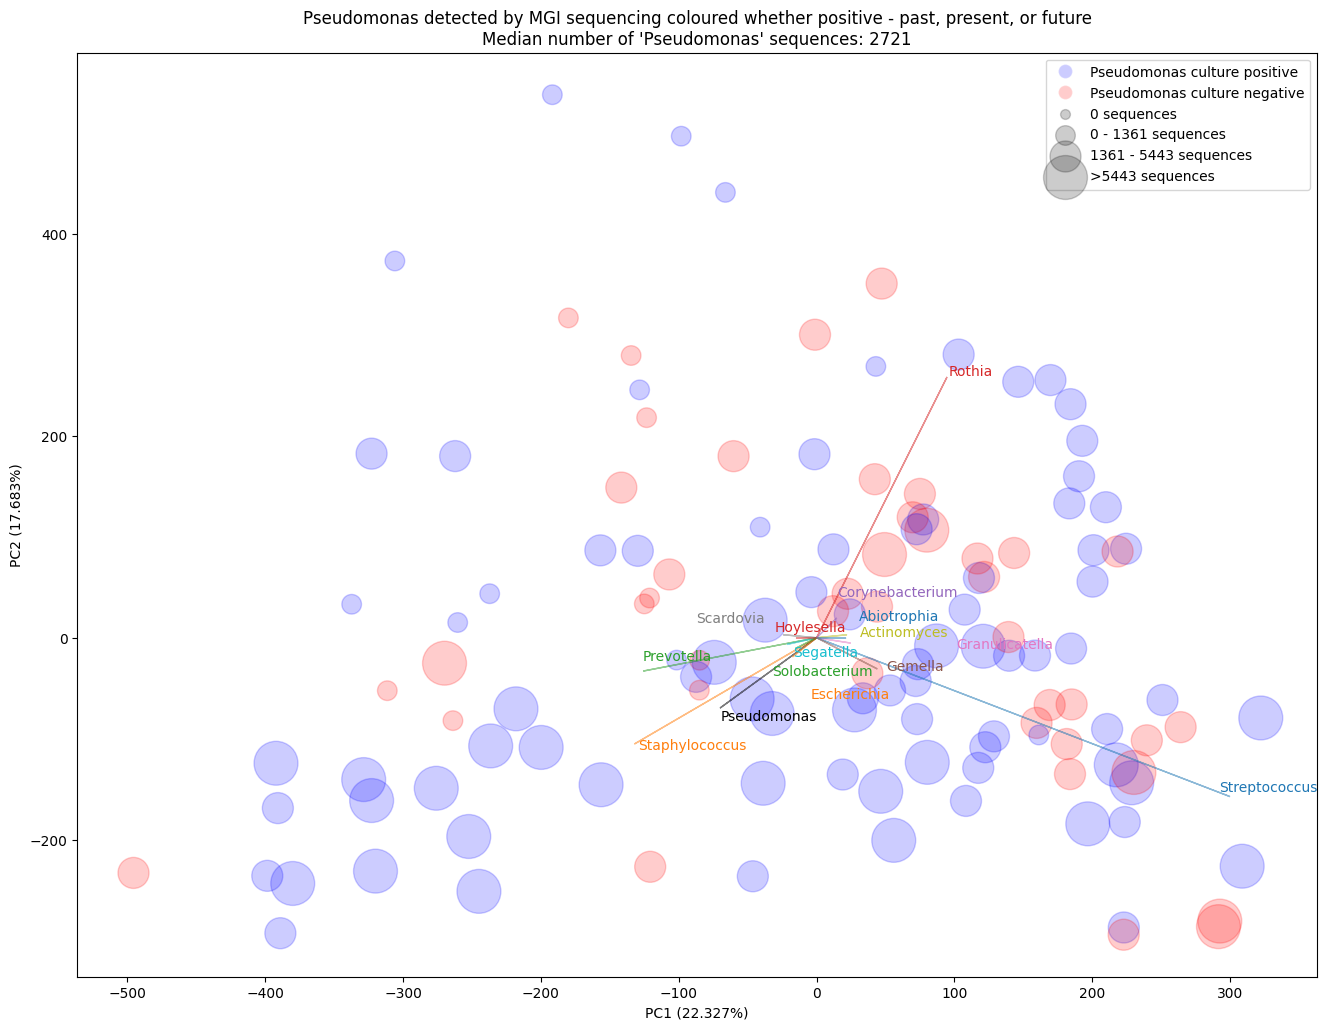

In [12]:
# Map colors based on the metadata column
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title(f'{genus} detected by {sequence_type} sequencing coloured whether positive - past, present, or future' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'PC1 ({pc1_variance:.3f}%)')
plt.ylabel(f'PC2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas:
    # specifically add Pseudomonas
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


# plt.savefig('img/MGI_genus_pseudomonas_past_present_future.png')
# Show the plot
plt.show()

## Colour by separate columns to see past, present, or future positivity.

First two columns (present/future), then all three.

Pseudomonas detected by MGI sequencing coloured by Pseudomonas culture status
Median number of 'Pseudomonas' sequences: 2721


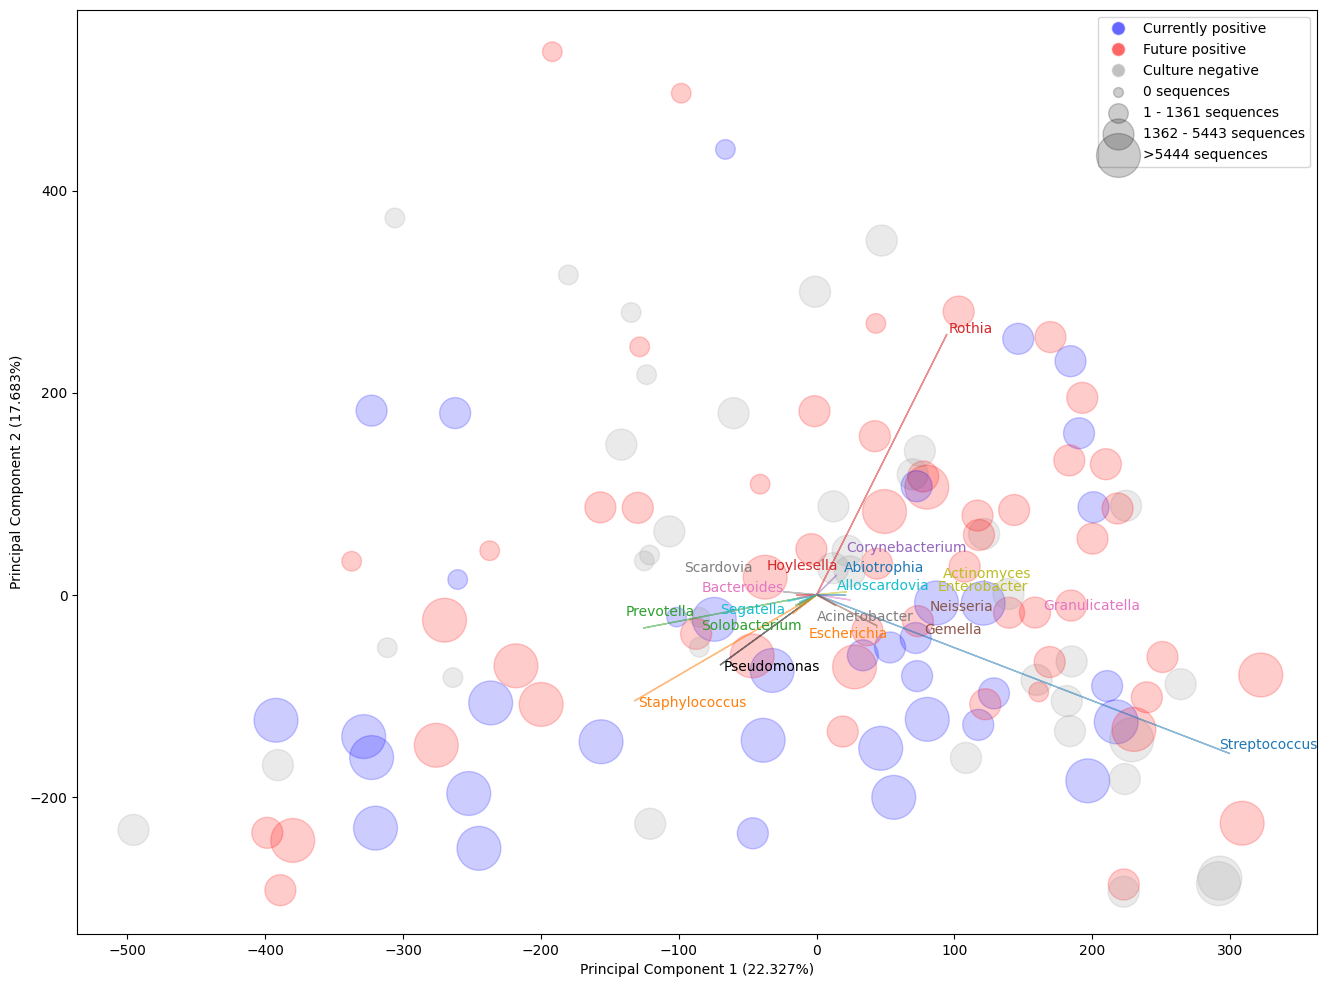

In [18]:
columns_to_check = [
    'CS_Pseudomonas aeruginosa',
    'N12M_Pseudomonas aeruginosa'
]
col_labels = {
    'CS_Pseudomonas aeruginosa' : 'Currently positive',
    'P12M_2_Pseudomonas aeruginosa' : 'Previously positive', 
    'N12M_Pseudomonas aeruginosa' : 'Future positive'
}

# --- Color palette (Okabe–Ito; color-blind friendly) ---
palette_OI = {
    columns_to_check[0]: '#0072B2',  # blue
    columns_to_check[1]: '#E69F00',  # orange
    'None': '#999999',               # grey 
}

palette = {
    columns_to_check[0]: 'blue',  # blue
    columns_to_check[1]: 'red',  # orange
    'None': '#999999',               # grey 
}

# Vectorized labeling: first True wins (priority is the order in columns_to_check)
vals = metadata[columns_to_check].astype(bool)
labels = np.select(
    [vals[c].values for c in columns_to_check],
    columns_to_check,
    default='None'
)
labels = pd.Series(labels, index=metadata.index)

# Map labels to colors
colours = labels.map(palette)

# === Plot the PCA results ===
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)

title_text = 'Pseudomonas detected by MGI sequencing coloured by Pseudomonas culture status' + f"\nMedian number of '{genus}' sequences: {md:.0f}"
#plt.title(title_text)
print(title_text)   

plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# --- Add the loadings (with Pseudomonas highlighted in black) ---
maxloadings = min(20, len(loadings))
plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas and 'Pseudomonas' in top_loadings_df.index:
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

adjust_text(texts)

# --- Legend for color categories ---
legend_handles = []
for key in [columns_to_check[0], columns_to_check[1], 'None']:
    legend_handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w',
            label=col_labels[key] if key != 'None' else 'Culture negative',
            markerfacecolor=palette[key], alpha=0.6, markersize=10
        )
    )

small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]+1:.0f} - {bins[2]:.0f} sequences',
                         alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]+1:.0f} - {bins[3]:.0f} sequences',
                         alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]+1:.0f} sequences',
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=legend_handles + [small_patch, med1_patch, med2_patch, big_patch])
plt.savefig('final_images/MGI_genus_pseudomonas_present_future.png')
plt.show()


In [19]:
maxloadings

20

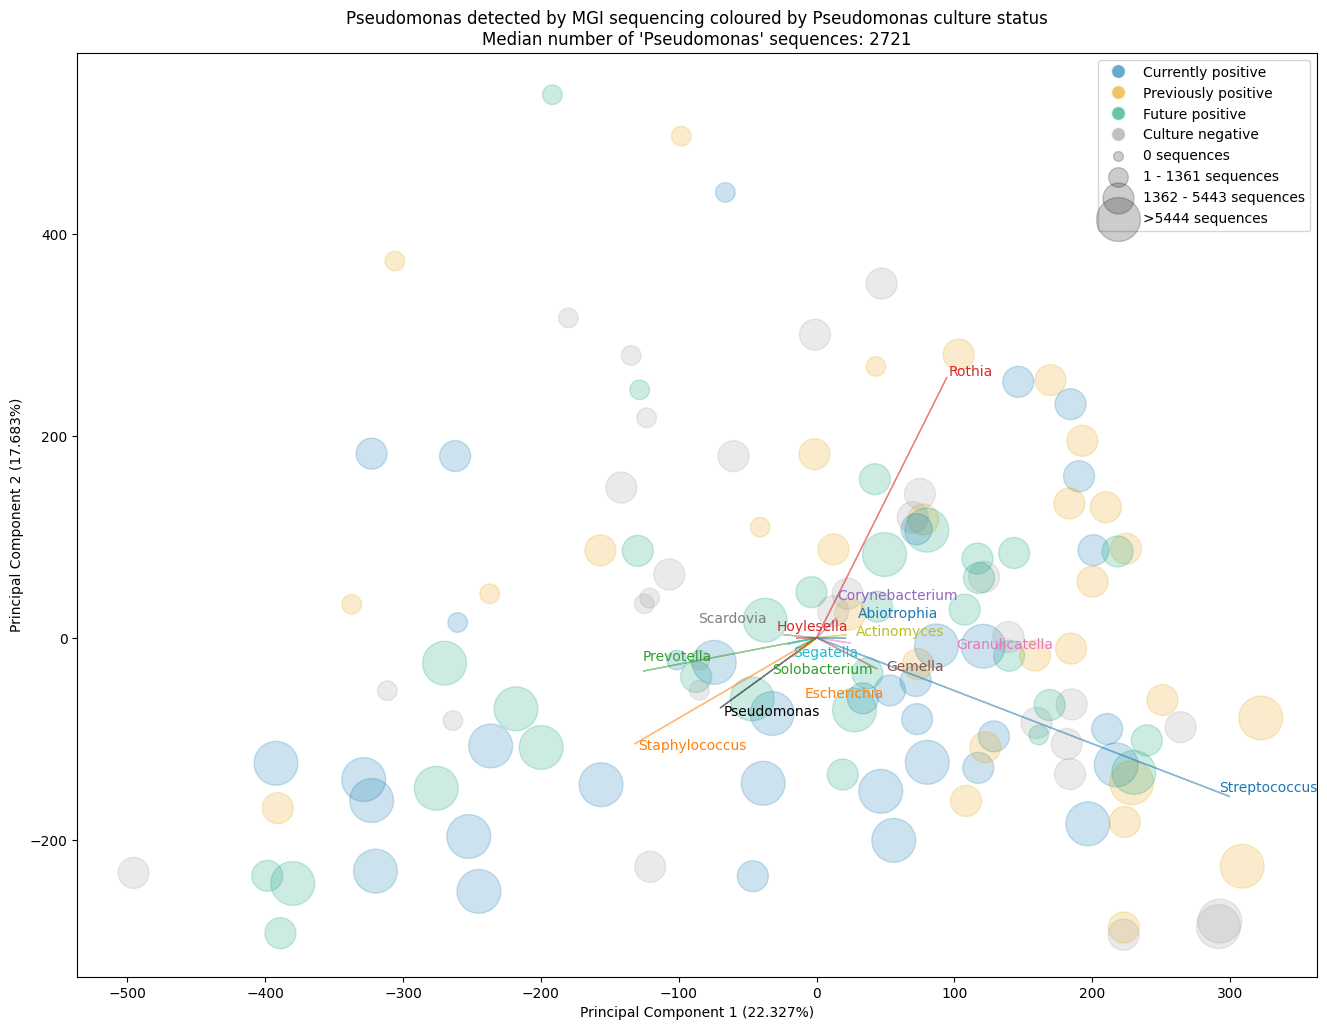

In [14]:
# === Choose your three metadata columns ===
columns_to_check = [
    'CS_Pseudomonas aeruginosa',
    'P12M_2_Pseudomonas aeruginosa', 
    'N12M_Pseudomonas aeruginosa'
]
col_labels = {
    'CS_Pseudomonas aeruginosa' : 'Currently positive',
    'P12M_2_Pseudomonas aeruginosa' : 'Previously positive', 
    'N12M_Pseudomonas aeruginosa' : 'Future positive'
}

# --- Color palette (Okabe–Ito; color-blind friendly) ---
palette = {
    columns_to_check[0]: '#0072B2',  # blue
    columns_to_check[1]: '#E69F00',  # orange
    columns_to_check[2]: '#009E73',  # green
    'None': '#999999',               # grey (no column True)
}

# Vectorized labeling: first True wins (priority is the order in columns_to_check)
vals = metadata[columns_to_check].astype(bool)
labels = np.select(
    [vals[c].values for c in columns_to_check],
    columns_to_check,
    default='None'
)
labels = pd.Series(labels, index=metadata.index)

# Map labels to colors
colours = labels.map(palette)

# === Plot the PCA results ===
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title(
    'Pseudomonas detected by MGI sequencing coloured by Pseudomonas culture status'
    + f"\nMedian number of '{genus}' sequences: {md:.0f}"
)
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# --- Add the loadings (with Pseudomonas highlighted in black) ---
maxloadings = min(15, len(loadings))
plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    if top_loadings_df.index[i] == 'Pseudomonas':
        found_pseudomonas = True
        c = 'black'
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

if not found_pseudomonas and 'Pseudomonas' in top_loadings_df.index:
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

adjust_text(texts)

# --- Legend for color categories ---
legend_handles = []
for key in [columns_to_check[0], columns_to_check[1], columns_to_check[2], 'None']:
    legend_handles.append(
        plt.Line2D(
            [0], [0], marker='o', color='w',
            label=col_labels[key] if key != 'None' else 'Culture negative',
            markerfacecolor=palette[key], alpha=0.6, markersize=10
        )
    )


small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]+1:.0f} - {bins[2]:.0f} sequences',
                         alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]+1:.0f} - {bins[3]:.0f} sequences',
                         alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]+1:.0f} sequences',
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=legend_handles + [small_patch, med1_patch, med2_patch, big_patch])

plt.show()


# One pwCF Outlier

In the subsystems data, we found a single outlier pwCF who has a lot of flagellar subsystems (see MGI_Subsystems.ipynb)

df[[x for x in df.columns if x.startswith('1128691_')]].sort_values(by='1128691_20171206_S', ascending=False)

In [15]:
pd.options.display.float_format = '{:,.2f}'.format
wants = [x for x in df.index if x.startswith('1128691_')]
df.loc[wants,['Pseudomonas', 'Streptococcus']]

taxonomy,Pseudomonas,Streptococcus
1128691_20171206_S,"467,795.40","42,038.88"
1128691_20171218_S,"405,929.25","63,293.14"
1128691_20180116_S,"473,029.50","22,022.79"


In [16]:
intpwcf = df.loc[wants,:]
intpwcf = intpwcf.loc[:,intpwcf.sum() > 2000]
intpwcf

taxonomy,Actinomyces,Schaalia,Alloscardovia,Rothia,Bacillus,Gemella,Listeria,Staphylococcus,Streptococcus,Veillonella,...,Neisseria,Enterobacter,Escherichia,Klebsiella,Serratia,Acinetobacter,Pseudomonas,Stutzerimonas,Vibrio,Stenotrophomonas
1128691_20171206_S,"3,124.61",734.57,32.25,"11,670.70",820.57,"2,454.54","3,020.69","4,590.16","42,038.88","1,160.98",...,727.40,"1,777.30","5,195.74","5,887.31","1,175.31","3,880.68","467,795.40","1,239.81","1,315.06","3,232.11"
1128691_20171218_S,"3,915.97","1,235.73",22.57,"19,675.78",767.39,"3,820.05","3,182.43","21,825.61","63,293.14","3,063.94",...,812.54,"1,760.49","5,416.90","5,902.17","1,089.02","3,374.28","405,929.25",964.89,"1,207.52","3,007.51"
1128691_20180116_S,"5,790.54",411.01,"2,283.96","8,579.16","2,226.73","1,956.19","2,861.45","1,862.55","22,022.79",551.48,...,681.55,"1,498.36","5,405.55","5,790.54","1,045.73","3,782.32","473,029.50","1,154.99","1,342.28","2,793.82"


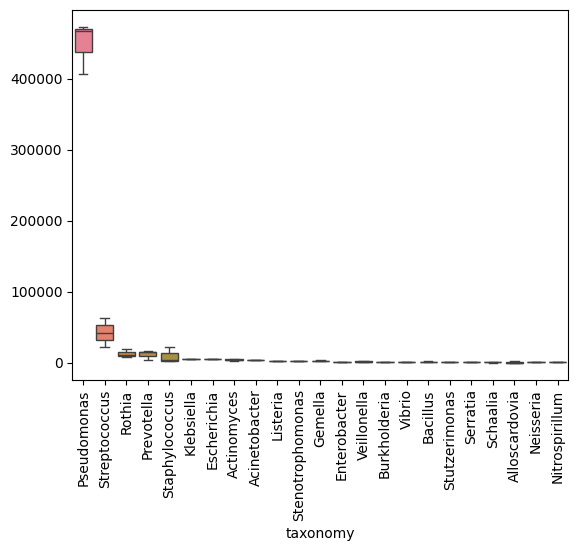

In [17]:
sns.boxplot(data=intpwcf.loc[:,intpwcf.sum().sort_values(ascending=False).index])
plt.xticks(rotation=90)
plt.show()